In [1]:
from typing import Callable, Optional

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

### 2.3b)

In [6]:
def naive_policy(observations: npt.NDArray[np.float64]) -> int:
    """
    Naive policy only checking for pole angle.
    :param observations: Array of environmental observations.
    :return: direction encoding
    """
    _, _, pole_angle, _ = observations
    # move left if pole angle is negative, otherwise move right
    return 0 if pole_angle < 0 else 1

def custom_policy(observations: npt.NDArray[np.float64]) -> int:
    """
    Policy taking the cart velocity and pole angle into account.
    :param: observations as numpy array
    :return: direction
    """
    # extract required observations
    _, cart_velocity, pole_angle, _ = observations
    # if pole angle is relatively small to the cart velocity
    if cart_velocity > pole_angle * 20:
        # check if we are still accelerating
        if cart_velocity >= 1:
            # move right
            return 1
        # otherwise move left
        return 0
    # otherwise, if we are still accelerating enough
    elif cart_velocity >= 1:
        # move left
        return 0
    # else, move right
    return 1

def simulate_policy(
        environment: gym.Env, 
        policy_func: Callable[[npt.NDArray[np.float64]], int], 
        episodes: int = 200,
        logs: bool = False
) -> np.float64:
    """
    Auxiliary function for simulating cart pole episodes.
    :param environment: Gymnasium Environment
    :param policy_func: Policy function to determine the next action.
    :param episodes: Number of episodes to run
    :param logs: Whether to log results or not.
    :return: Mean reward over all episodes.
    """
    # init rewards array
    rewards: list[float] = []
    # for each episode
    for i in range(episodes):
        # take the observation
        observation, _ = environment.reset()
        # reset total reward
        total_reward: float = 0
        episode_over: bool = False
        # repeat until the episode is not over
        while not episode_over:
            # select an action based on provided policy
            action = policy_func(observation)
            # extract observations from environment
            observation, reward, done, truncated, info = environment.step(action)
            # auxiliary logs
            if logs:
                print(f"Episode: {i}, Action: {action}, State: {observation}, Reward: {reward}, Info: {info}")
            # add reward to current episode
            total_reward += reward
            # check if episode is over
            episode_over = truncated or done
            # again auxiliary logs
            if done and logs:
                print("Episode ended.")
        # store the reward of the episode
        rewards.append(total_reward)
    # close environment after all episodes
    environment.close()
    # return mean of all rewards
    return np.mean(rewards)

Evaluate naive policy

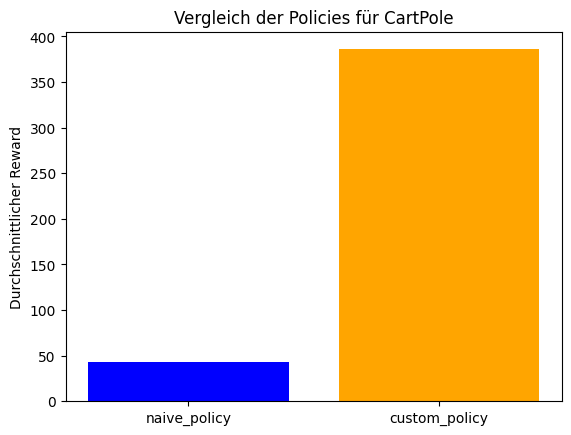

In [7]:
# store policy rewards
mean_rewards = {
    'naive_policy': simulate_policy(env, naive_policy), 
    'custom_policy': simulate_policy(env, custom_policy)
}

# visualize the policies
labels = list(mean_rewards.keys())
values = list(mean_rewards.values())

plt.bar(labels, values, color=['blue', 'orange'])
plt.ylabel('Durchschnittlicher Reward')
plt.title('Vergleich der Policies für CartPole')
plt.show()

### 2.3c)

In [3]:
class DiscreteCartEnvironment(gym.ObservationWrapper):
    """Observation Wrapper for discrete CartPole environment"""
    
    def __init__(self, environment: gym.Env, num_bins: int = 20) -> None:
        """
        Constructor
        :param environment: 
        :param num_bins: 
        """
        super().__init__(environment)
        self.num_bins: int = num_bins
        self.num_states: int = pow(num_bins, 4) 
        self.observation_space = gym.spaces.Discrete(self.num_states)
        self.lookup_table: Optional[dict[int, int]] = None
        
    def _discretize(self, value, min_value, max_value):
        """Diskretisieren eines kontinuierlichen Wertes."""
        bin_size = (max_value - min_value) / self.num_bins
        return int(np.clip((value - min_value) / bin_size, 0, self.num_bins - 1))

    def observation(self, observation) -> int:
        """Diskretisieren aller Beobachtungen."""
        x = self._discretize(observation[0], -2.4, 2.4)  # Position der Cart
        x_dot = self._discretize(observation[1], -3.0, 3.0)  # Geschwindigkeit der Cart
        theta = self._discretize(observation[2], -0.209, 0.209)  # Neigungswinkel des Pendels
        theta_dot = self._discretize(observation[3], -3.5, 3.5)  # Geschwindigkeit des Pendels
        return x + (self.num_bins * (x_dot + (self.num_bins * (theta + (self.num_bins * theta_dot)))))
    
    def find_lookup_table(self, episodes: int = 200, exploration_rate: float = 0.1) -> npt.NDArray[np.int64]:
        """
        Find optimal actions and store them in lookup table using epsilon greedy policy.
        :return: 
        """
        bandits = [EpsilonGreedyBandit(epsilon=exploration_rate) for _ in range(self.num_states)]
        rewards: npt.NDArray[np.np.int64] = np.zeros((self.num_states, episodes), dtype=np.int64)

        for episode in range(episodes):
            observation, _ = env.reset()
            episode_over: bool = False
            
            while not episode_over:
                state = self.observation(observation)  # Diskreter Zustand
                action = bandits[state].select_action()  # Aktion wählen
                observation, reward, done, truncated, _ = env.step(action)  # Aktion ausführen
                bandits[state].update(action, reward)  # Q-Wert aktualisieren
                # store reward for current bandit of current episode
                rewards[self.observation(observation)][episode] += reward
                episode_over = truncated or done
        # store best actions in lookup table
        self.lookup_table = {idx: bandit.get_optimal_action() for idx, bandit in enumerate(bandits)}
        return rewards
        
    @property
    def cart_lookup_table(self) -> Optional[dict[int, int]]:
        """Return the lookup table"""
        return self.lookup_table


class EpsilonGreedyBandit:
    """Class representing an epsilon-greedy bandit"""
    
    def __init__(self, epsilon: float) -> None:
        self.n_actions: int = 2
        self.epsilon: float = epsilon
        self.action_values: npt.NDArray[np.float64] = np.zeros(self.n_actions)
        self.action_counts: npt.NDArray[np.float64] = np.zeros(self.n_actions)

    def select_action(self) -> int:
        """Select best action based on epsilon greedy policy"""
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.action_values).astype(np.int64)

    def update(self, action: int, reward: int) -> None:
        """
        Update Q values
        :param action: 
        :param reward: 
        :return: None
        """
        self.action_counts[action] += 1
        self.action_values[action] += (reward - self.action_values[action]) / self.action_counts[action]
        
    def get_optimal_action(self) -> int:
        """
        Returns the optimal action for the bandit.
        :return: Index of highest action value (i.e., best action)
        """
        return np.argmax(self.action_values).astype(np.int64)

In [22]:
discrete_env = DiscreteCartEnvironment(env, num_bins=5)
cart_rewards = discrete_env.find_lookup_table(episodes=500)

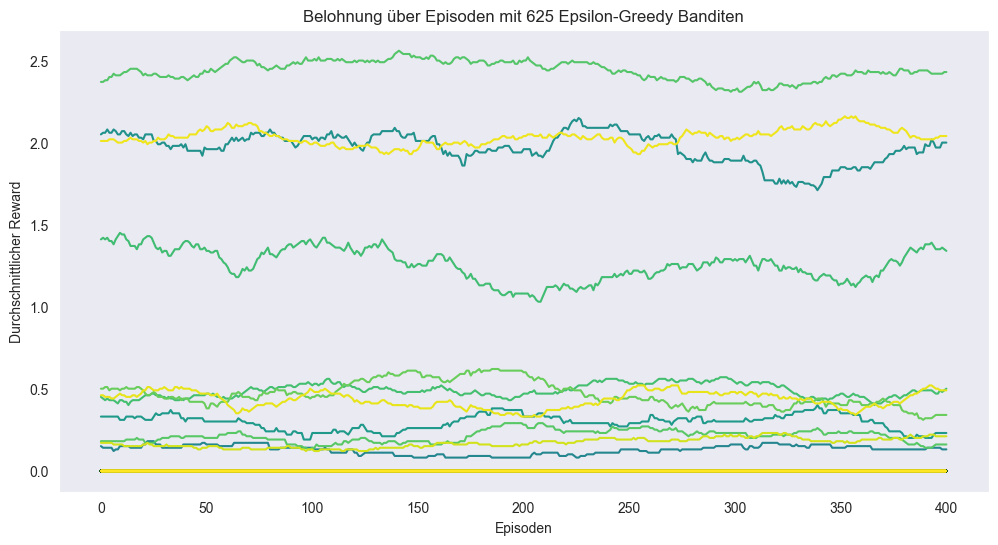

In [24]:
num_bandits = cart_rewards.shape[0]
colors = plt.cm.viridis(np.linspace(0, 1, num_bandits))

plt.figure(figsize=(12, 6))

for bandit_idx in range(num_bandits):
    # Apply moving average for smoothing the reward curve
    smoothed_rewards = np.convolve(cart_rewards[bandit_idx], np.ones(100) / 100, mode='valid')
    plt.plot(smoothed_rewards, label=f'Bandit {bandit_idx}', color=colors[bandit_idx])

plt.xlabel('Episoden')
plt.ylabel('Durchschnittlicher Reward')
plt.title(f'Belohnung über Episoden mit {num_bandits} Epsilon-Greedy Banditen')
plt.grid()
plt.show()